# Creating custom datablocks for 3D images and fastai

In [1]:
import SimpleITK as sitk
import re
import pathlib

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [2]:
from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.data import *
from faimed3d.models import *


## Load data

In [3]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')

train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))

To reduce complexity of the data, only the T2 map will be used for the first runs. 

In [4]:
random.shuffle(valid_files)

In [5]:
files = train_files + valid_files

In [6]:
# take only T2 images for now
subset_files =[]
for f in files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_files.append(Path(m.string))

In [7]:
segmentation_files = [(p.parent/'Annotation').ls()[0] for p in subset_files]

## Construct databunch

In [8]:
def GreatGreatGrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the great great grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _great_great_grandparent_idxs(o, train_name),_great_great_grandparent_idxs(o, valid_name)
    return _inner

In [9]:
def _great_great_grandparent_idxs(items, name):
    def _inner(items, name): return mask2idxs(Path(o).parent.parent.parent.parent.name == name for o in items)
    return [i for n in L(name) for i in _inner(items,n)]

In [10]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              MaskBlock3D(codes = ['void', "peripheral", 'transitional', 'cancer'])),
    get_x = lambda x: x[0],
    get_y = lambda x: x[1], 
    item_tfms = [
        ResizeCrop3D(crop_by = (0.1, 0.15, 0.15), resize_to = (20, 150, 150), perc_crop = True)],
    batch_tfms = [
        *aug_transforms_3d(p_all=0.25, do_rotate_by = False), 
        RandomCrop3D(((2, 2), (25,25), (25,25)), (1, 10, 10)), 
        PseudoColor, 
        ClampMask3D(0,2)],
    splitter = RandomSplitter())

In [11]:
d = pd.DataFrame({'image' : subset_files, 
                  'mask' : segmentation_files})

In [12]:
dls = mris.dataloaders(d, 
                       batch_size = 8, 
                       num_workers = 0,
                      )
dls.valid.bs = 6 # defaults to 64 and will cause Cuda out of Memory errors

## Train the model

In [13]:
# working example with CE loss, but bad segmentations

def loss_fun(i, t):
    t = t.long().squeeze()
    return nn.CrossEntropyLoss( weight = tensor([0.5, 1.5, 1.5, 10]).cuda())(i, t)

In [14]:
from sklearn.metrics import matthews_corrcoef
from faimed3d.augment import to_one_hot

In [15]:
learn = Learner(dls, 
                UNet3D(n_channels = 1, n_classes = 3),
                opt_func = SGD, 
                loss_func = MCCLossMulti(n_classes = 3), 
                model_dir = '../models/',
                cbs = SaveModelCallback(fname = 'unet-whole-prostate')
               )
learn = learn.to_fp16()
learn.unfreeze()

In [16]:
#learn.lr_find()

In [17]:
learn.fit_one_cycle(15, 0.5)

epoch,train_loss,valid_loss,time
0,0.958823,0.975563,00:44
1,0.900648,0.854445,00:28
2,0.870053,0.761748,00:28
3,0.832184,0.745167,00:28
4,0.792087,0.675488,00:28
5,0.752674,0.577244,00:28
6,0.745108,0.456736,00:29
7,0.690053,0.539999,00:28
8,0.665336,0.419067,00:29
9,0.637117,0.455535,00:29


Better model found at epoch 0 with valid_loss value: 0.9755626916885376.
Better model found at epoch 1 with valid_loss value: 0.8544447422027588.
Better model found at epoch 2 with valid_loss value: 0.7617482542991638.
Better model found at epoch 3 with valid_loss value: 0.745166540145874.
Better model found at epoch 4 with valid_loss value: 0.6754879355430603.
Better model found at epoch 5 with valid_loss value: 0.5772435665130615.
Better model found at epoch 6 with valid_loss value: 0.4567360579967499.
Better model found at epoch 8 with valid_loss value: 0.4190670847892761.
Better model found at epoch 11 with valid_loss value: 0.3639180362224579.
Better model found at epoch 12 with valid_loss value: 0.3404484689235687.


In [18]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-0')

Path('../models/unet-whole-prostate-0.pth')

In [19]:
learn.fit_one_cycle(15, 0.25)

epoch,train_loss,valid_loss,time
0,0.515961,0.346745,00:28
1,0.491397,0.366070,00:28
2,0.504838,0.552070,00:28
3,0.505266,0.340707,00:28
4,0.530704,0.391957,00:28
5,0.533256,0.514837,00:28
6,0.532141,0.372534,00:28
7,0.547642,0.357927,00:28
8,0.518723,0.366320,00:28
9,0.529721,0.351885,00:28


Better model found at epoch 0 with valid_loss value: 0.3467451333999634.
Better model found at epoch 3 with valid_loss value: 0.3407071828842163.
Better model found at epoch 10 with valid_loss value: 0.32099226117134094.
Better model found at epoch 11 with valid_loss value: 0.31360924243927.


In [20]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-1')

Path('../models/unet-whole-prostate-1.pth')

In [21]:
learn.fit_one_cycle(10, 0.1)

epoch,train_loss,valid_loss,time
0,0.569664,0.321740,00:28
1,0.469508,0.336929,00:28
2,0.444255,0.293779,00:28
3,0.469251,0.346113,00:28
4,0.475819,0.298638,00:28
5,0.487186,0.316761,00:28
6,0.482611,0.302786,00:28
7,0.495215,0.309042,00:28
8,0.480427,0.299713,00:29
9,0.464754,0.304441,00:29


Better model found at epoch 0 with valid_loss value: 0.3217402398586273.
Better model found at epoch 2 with valid_loss value: 0.2937789857387543.


In [22]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-2')

Path('../models/unet-whole-prostate-2.pth')

In [23]:
learn.fit_one_cycle(15, 0.01)

epoch,train_loss,valid_loss,time
0,0.438320,0.304991,00:28
1,0.467092,0.306565,00:28
2,0.440316,0.290657,00:28
3,0.444217,0.300298,00:28
4,0.454815,0.307897,00:28
5,0.466386,0.299894,00:29
6,0.447092,0.299899,00:28
7,0.443672,0.313938,00:28
8,0.456768,0.308943,00:28
9,0.447713,0.302635,00:28


Better model found at epoch 0 with valid_loss value: 0.3049907386302948.
Better model found at epoch 2 with valid_loss value: 0.2906574010848999.


In [24]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-3')

Path('../models/unet-whole-prostate-3.pth')

In [25]:
learn.fit_one_cycle(15, 0.001)

epoch,train_loss,valid_loss,time
0,0.501103,0.293258,00:28
1,0.442838,0.298818,00:28
2,0.447712,0.288646,00:28
3,0.458639,0.296045,00:29
4,0.445075,0.299147,00:28
5,0.451995,0.307194,00:28
6,0.445221,0.292058,00:28
7,0.439703,0.301457,00:28
8,0.457669,0.303028,00:28
9,0.445194,0.302661,00:28


Better model found at epoch 0 with valid_loss value: 0.2932576835155487.
Better model found at epoch 2 with valid_loss value: 0.28864607214927673.


In [26]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-4')

Path('../models/unet-whole-prostate-4.pth')

In [27]:
learn.fit_one_cycle(50, 0.0001)

epoch,train_loss,valid_loss,time
0,0.442892,0.295985,00:29
1,0.530037,0.311912,00:29
2,0.474141,0.315268,00:28
3,0.448491,0.309663,00:28
4,0.473010,0.315553,00:28
5,0.488225,0.303091,00:28
6,0.478145,0.303456,00:28
7,0.474878,0.300777,00:28
8,0.463996,0.290139,00:28
9,0.461058,0.301164,00:28


Better model found at epoch 0 with valid_loss value: 0.29598453640937805.
Better model found at epoch 8 with valid_loss value: 0.2901390790939331.
Better model found at epoch 22 with valid_loss value: 0.28702881932258606.


In [28]:
learn = learn.load('unet-whole-prostate')
#learn.save('unet-whole-prostate-5')

In [29]:
x_in, y_pred, y_orig = learn.get_preds(with_input = True)

In [30]:
from faimed3d.augment import to_one_hot

x_in = TensorDicom3D(x_in)
y_pred = TensorDicom3D(y_pred)
y_orig = TensorDicom3D(to_one_hot(y_orig, 4).float())

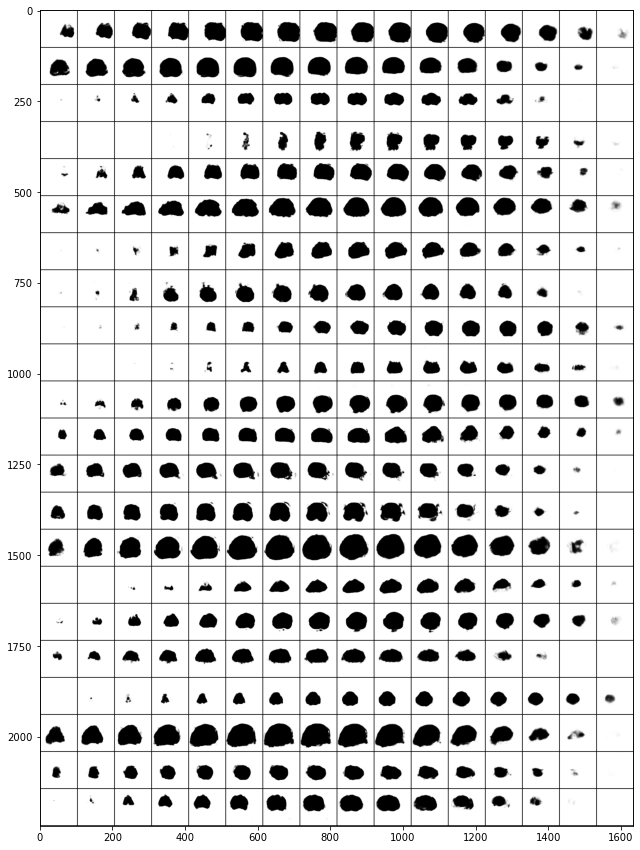

In [43]:
TensorDicom3D(y_pred[:, 0, :, :, :]).show(add_to_existing = False, cmap = "gray", nrow = 16)
#TensorDicom3D(y_orig[:, 0, :, :, :]).show(add_to_existing = True, alpha = 0.25, cmap = "jet", nrow = 16)

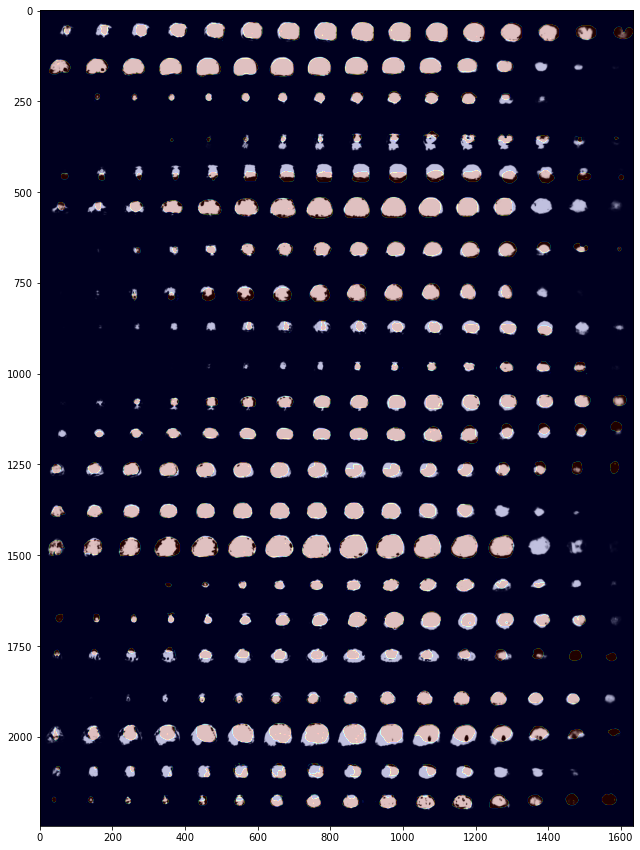

In [39]:
TensorDicom3D(y_pred[:, 1, :, :, :]).show(add_to_existing = False, alpha = 1, cmap = "gray", nrow = 16)
TensorDicom3D(y_orig[:, 1, :, :, :]).show(add_to_existing = True, alpha = 0.25, cmap = "jet", nrow = 16)

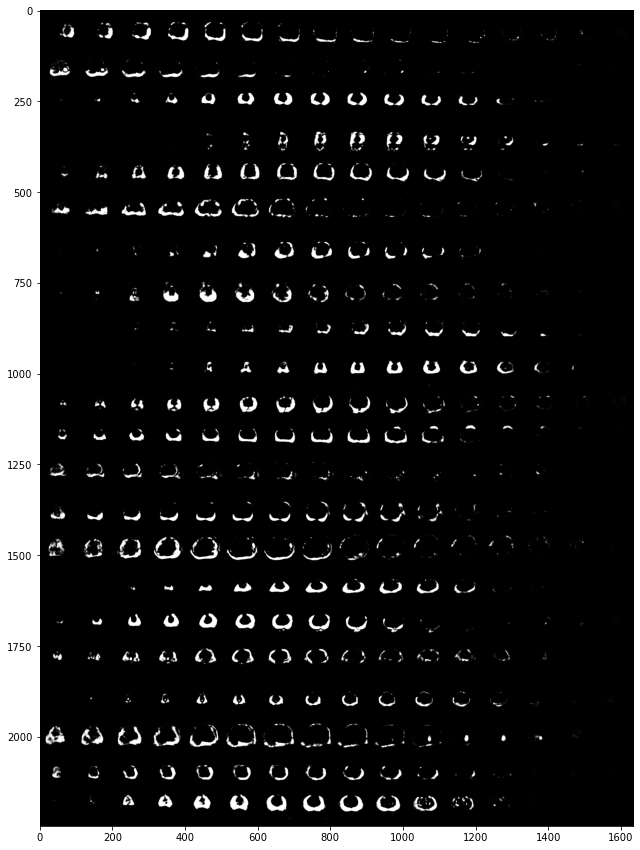

In [38]:
TensorDicom3D(y_pred[:, 2, :, :, :]).show(add_to_existing = False, alpha = 1, cmap = "gray", nrow = 16)
#TensorDicom3D(y_orig[:, 2, :, :, :]).show(add_to_existing = True, alpha = 0.25, cmap = "jet", nrow = 16)